In [1]:
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
from models.enet import enet
model = enet(3, 14).to(device)
model_state_dict = torch.load('models_pth_files/cpu_no_depth_enet_epoch_400.pth', map_location=device)
model.load_state_dict(model_state_dict)
model = model.train()

# print number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'{total_params:,} total parameters.')

# print number of trainable parameters
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} training parameters.')

350,988 total parameters.
350,988 training parameters.


In [4]:
import time
def model_speed(model, in_val, N=1000):
    """
    return average inference time of model
    """
    model.eval()
    with torch.no_grad():
        start = time.time()
        for i in range(N):
            model(in_val)
        end = time.time()
    return (end - start) / N
model_speed(model, torch.rand(16, 3, 512, 512).to(device))

0.033321067571640016

In [6]:

from dataloaders.NYU_loader import NYUv2
train_dl = NYUv2(
    root="content/NYUv2/",
    train=False, 
    download=False, 
    img_size=(512, 512), 
    load_rgb=True, 
    load_depth=True, 
    load_seg=True, 
    load_sn=False,
    random_crop=False,
    random_flip=False,
)

train_loader = torch.utils.data.DataLoader(
    dataset = train_dl,
    batch_size = 4,
    shuffle = False)

In [7]:
from matplotlib import pyplot as plt
def plot(rgb, actual, pred):
    rgb = rgb.permute(1, 2, 0).numpy()
    
    if actual.shape[0] == 1:
        actual = actual.squeeze(0)
    if pred.shape[0] == 1:
        pred = pred.squeeze(0)
    
    actual = actual.numpy()
    pred = pred.numpy()

    fig, ax = plt.subplots(1, 3, figsize=(10, 10))
    ax[0].imshow(rgb)
    ax[0].set_title("RGB")
    ax[1].imshow(actual)
    ax[1].set_title("Actual")
    ax[2].imshow(pred)
    ax[2].set_title("Predicted")


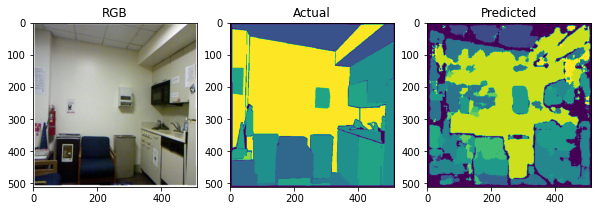

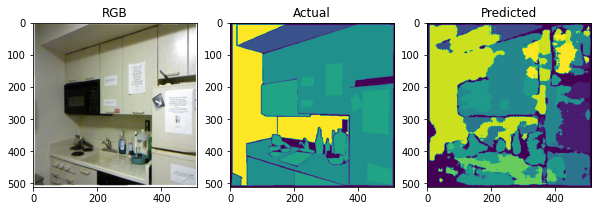

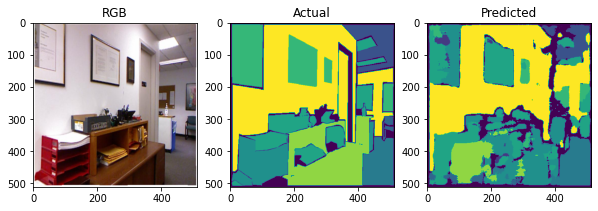

In [8]:
import utils.utils as utils

data = next(iter(train_loader))
with torch.no_grad():
    for N in range(3):
        rgb = data[0].to(device)
        depth = data[2].to(device)
        seg = data[1].to(device)
        in_val = rgb
        out = model(in_val)
        pred_mask = utils.convert_to_segmentation(out) 
        plot(rgb[N].cpu(), seg[N].cpu(), pred_mask[N].cpu())


In [9]:
import utils.utils as utils
import importlib
importlib.reload(utils)
IoUs = []
#model.train()
##model.eval()
with torch.no_grad():
    for i, data in enumerate(train_loader):
        x = data[0].to(device=device).float()
        y = data[1].to(device=device).float()
        d = data[2].to(device=device).float()

        pred = model(x)

        y = y.detach()
        y_hot = utils.convert_to_one_hot(y, classes=14, scale_values=False)

        #compute the mean UoI with utils.meanIoU
        pred = pred.detach().cpu()
        y_hot = y_hot.detach().cpu()
        mIoU = utils.meanIoU(pred, y_hot, 14)
        IoUs.append(mIoU)

print("Mean IoU: ", sum(IoUs)/len(IoUs))

Mean IoU:  tensor(0.3057)


In [10]:
def compute_pixel_accuracy(pred, y):
    """
    pred - torch tensor of shape (N, C, H, W)
    y - torch tensor of shape (N, C, H, W)
    """

    pred_mask = utils.convert_to_segmentation(pred)
    y_mask = utils.convert_to_segmentation(y)

    correct = (pred_mask == y_mask).sum()
    total = pred_mask.shape[0] * pred_mask.shape[1] * pred_mask.shape[2]

    return correct / total


In [11]:
pixel_accuaries = []

with torch.no_grad():
    for i, data in enumerate(train_loader):
        x = data[0].to(device=device).float()
        y = data[1].to(device=device).float()
        d = data[2].to(device=device).float()

        pred = model(x)

        y = y.detach()
        y_hot = utils.convert_to_one_hot(y, classes=14, scale_values=False)

        #compute the mean UoI with utils.meanIoU
        pred = pred.detach()
        y_hot = y_hot.detach()
        pixel_accuaries.append(compute_pixel_accuracy(pred, y_hot))

print(f"Mean pixel accuracy: ", (sum(pixel_accuaries)/len(pixel_accuaries)).item() * 100, "%")

Mean pixel accuracy:  53.86075973510742 %


In [9]:
# load image at path into a tensor and resize to 512x512

import torchvision.transforms as transforms
import PIL.Image as Image

def load_image(path):
    image = Image.open(path)
    image = transforms.Resize((512, 512))(image)
    image = transforms.ToTensor()(image)
    image = image.unsqueeze(0)
    return image

sample_image = load_image("samples/room.png")

In [10]:
import utils.utils as utils
def segment_image(image): 
    image = image.to(device=device)
    pred = model(image)
    pred = utils.convert_to_segmentation(pred)
    return pred

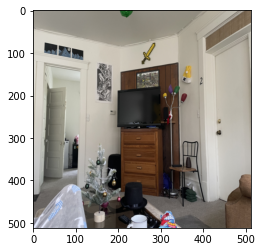

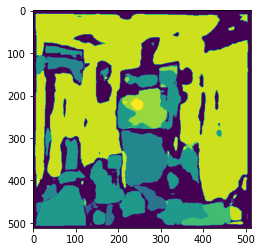

In [11]:
from matplotlib import pyplot as plt
plt.imshow(sample_image[0].permute(1, 2, 0))

pred = segment_image(sample_image)
plt.figure()
plt.imshow(pred[0].cpu())